In [1]:
#import packages
import os
import gc
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import pathlib
from torch.utils.data import Dataset

import numpy as np
#from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch
import torchvision
#from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights


#gradcam
import cv2


In [2]:
#good practice to provide class labels as integer arrays

CLASSES = ["BLD", "No BLD"]
class_mapping = {label: idx for idx, label in
                 enumerate(np.unique([CLASSES]))}


In [3]:
#dictonary to modify transformations
config = dict(
    rot=90,
    noise=0.05
)

In [4]:
#make sure image input size matches expected size for the spcific models

train_transform = transforms.Compose(
    #384x384 for efficientnet
    #224x225 for ResNEt and MobileNEt
    #256x256 for Swin
    [transforms.Resize([224,224]), #converts image to the pre-trained model dimension expectations
     #transforms.RandomRotation(degrees=config["rot"]),
     #transforms.RandomVerticalFlip(p=0.5),
     #transforms.RandomHorizontalFlip(p=0.5),
     transforms.Grayscale(3),
     transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
    ])

#validation preprocessing
val_transform = transforms.Compose(
    [transforms.Resize([224,224]), #converts image to the pre-trained model dimension expectations
     transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
     ])
     

In [5]:
#import data
#images in directories converted to tensor format and classes obtained from direcory names
#add test folder once get more data

train_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/train', transform=train_transform)
#test_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/test', transform=val_transform)
val_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/val', transform=val_transform)

In [6]:
# Access the transformed image
image, label = train_dataset[0]
# Check the size of the transformed image
print(image.shape) #retuns [channel, height, width]. 3 indicates color. During training an additional element is added, batch_size


torch.Size([3, 224, 224])


In [7]:
#check class names
train_dataset.class_to_idx

{'BLD': 0, 'No_BLD': 1}

In [8]:
#check number of images in each set
print(f'Number of images in training dataset: {len(train_dataset)}')
#print(f'Number of images in testing dataset: {len(test_dataset)}')
print(f'Number of images in validation dataset: {len(val_dataset)}')

Number of images in training dataset: 82
Number of images in validation dataset: 26


In [9]:
#a hyperparameter to try changing
#batch_size = 4
batch_size = 16
#batch_size = 32

In [10]:
#dataloader
#output a batch of images and labels, one sample at a time

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
#                                         shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True)



In [33]:
# Clear memory

del model_RN
del optimizer

# Clear cache
torch.cuda.empty_cache()

# Run garbage collector
gc.collect()

2096

In [34]:
#Import model for training

#ResNet101 
#weights = ResNet101_Weights.DEFAULT
#model_RN = torchvision.models.resnet101(weights=weights)

weights = ResNet50_Weights.DEFAULT
model_RN = torchvision.models.resnet50(weights=weights)

In [35]:
#ResNet
#Intitalize model, not freezing layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#freeze layers
for param in model_RN.parameters():
    param.requires_grad = False

model_rn = model_RN
num_ftrs = model_rn.fc.in_features #print this out to confirm a value

num_classes = 2  # Replace with the number of classes in your dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_rn.fc = nn.Linear(in_features=model_rn.fc.in_features, out_features=num_classes)

model_rn = model_rn.to(device) #move model to this device



#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_rn.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [36]:
#Pg. 479 pytorch book
#modified to accomidate BCELoss format expectations in the pred output
#Pg. 473
#If returning 1 probablity from model(x_batch) (using [:,0]), then use BCE function
#If retunring 2 proabability values, use Cross entropy loss function

def train_1(model, num_epochs, train_d1, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for x_batch, y_batch, in train_d1:
            #output of forward pass a tensor with predictions for the batch
            pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
            #print(pred.size(), y_batch.size()) #use this to troubleshoot BCE error. Shapes should match
        
        #uncomment block
            loss = criterion(pred, y_batch.float()) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float() #calculating correct class from first column of pred tensor [:,0]
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_d1.dataset)
        accuracy_hist_train[epoch] /= len(train_d1.dataset)
        
        model.eval() 
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
                 #save probabilities from previously trained model
                outputs = model(x_batch)
                #print(f'pred {pred}')
                
                #saving largest probabilities in each batch
                #probabilities in logit format (from BCELoss)
                probs, preds = torch.max(outputs,1) 
                #print(f'preds {preds}')
                #print(f'probs {probs}')
                
                probability = torch.sigmoid(pred)
                #probability = torch.sigmoid(outputs)[0]
                #print(f'probability {probability}')
                #print(f'true labels {y_batch}')
                
                
               #uncomment block
                loss = criterion(pred, y_batch.float()) #BCE expects floar
                loss_hist_valid[epoch] += \
                    loss.item() * y_batch.size(0)
                is_correct = \
                    ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_d1.dataset)
            accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

            #Preparing data for evaluation
            #append values in list after loop   
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            #print(f'all preds 1 {all_preds}')
            #print(f'all labels 1 {all_labels}')
            
            #convert to np array  
            #all_preds = np.array(all_preds)
            #all_labels = np.array(all_labels)

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
            
            #all_preds = torch.tensor(all_preds)
            #all_labels = torch.tensor(all_labels)
            #print(f'all preds {all_preds}')
            #print(f'all labels {all_labels}')
        

        #uncomment block
        print(f'Epoch {epoch+1} '
              f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
              f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
              f'train_loss: {loss_hist_train[epoch]:.4f}, '
              f'val_loss: {loss_hist_valid[epoch]:.4f} ')

            

    # Compute precision
    precision = precision_score(all_labels, all_preds, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
    #calculate recall score
    recall = recall_score(all_labels, all_preds, average='binary')
    #Calculate f1 score
    f1 = f1_score(all_labels, all_preds, average='binary')

    # Calculate ROC AUC
    #need to confirm if sigmoid function is needed (all_predictions vs all_preds
    #auc = roc_auc_score(all_labels, all_predictions)
    auc = roc_auc_score(all_labels, all_preds)
        
                    

    print(f'Precision Score: {precision:.4f}, '
          f'Recall Score: {recall:.4f}, '
          f'F1 Score: {f1:.4f}, '
          f'ROC AUC: {auc:.4f}'
            )    

    #for graph
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds) 
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the ROC curve
    #plt.figure()  
    #plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve for Beech Leaf Disease Classification')
    #plt.legend()
    #plt.show()

    #returns these values that can be stored in a variable when the function is run
    return loss_hist_train, loss_hist_valid, \
        accuracy_hist_train, accuracy_hist_valid, \
        precision, recall, f1, fpr, tpr, auc

In [37]:
#Train model not frozen
torch.manual_seed(1)
num_epochs = 2
hist = train_1(model_rn, num_epochs, trainloader, valloader)

#print(len(hist))
#print(hist[0:9])
#saved variable 'hist' contains the values from each epoch of loss_hist_train [0],
#loss_hist_valid [1], accuracy_hist_train [2], accuracy_hist_valid [3],
#contains single value of precision [4], recall, [5], f1 [6], fpr [7], tpr [8], auc [9]

Epoch 1 accuracy: 0.6829, val_accuracy: 0.6154, train_loss: 0.6228, val_loss: 0.6236 
Epoch 2 accuracy: 0.6829, val_accuracy: 0.6154, train_loss: 0.5844, val_loss: 0.6065 
Precision Score: 0.4000, Recall Score: 1.0000, F1 Score: 0.5714, ROC AUC: 0.5000


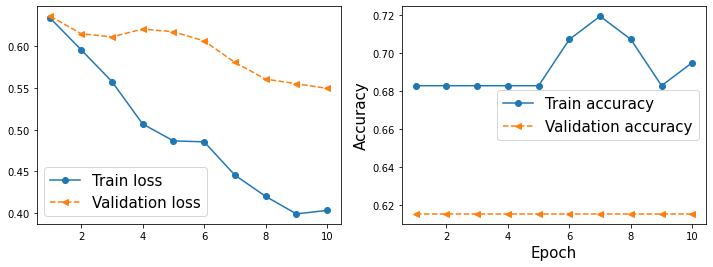

In [18]:
#Plot learning curve
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize = 15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<',
        label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size=15)
plt.show()




In [53]:
# clear memory


model = model_RN()
del model_RN
optimizer.state_dict().clear()
del optimizer

# Clear cache
torch.cuda.empty_cache()

# Run garbage collector
gc.collect()

TypeError: forward() missing 1 required positional argument: 'x'

In [49]:
#Import model for training

#ResNet101 
#weights = ResNet101_Weights.DEFAULT
#model_RN = torchvision.models.resnet101(weights=weights)

weights = ResNet50_Weights.DEFAULT
model_RN = torchvision.models.resnet50(weights=weights)

In [50]:
#ResNet
#Intitalize model, not freezing layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#freeze layers
for param in model_RN.parameters():
    param.requires_grad = True

model_rn = model_RN
num_ftrs = model_rn.fc.in_features #print this out to confirm a value

num_classes = 2  # Replace with the number of classes in your dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_rn.fc = nn.Linear(in_features=model_rn.fc.in_features, out_features=num_classes)

model_rn = model_rn.to(device) #move model to this device



#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_rn.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [51]:
#Pg. 479 pytorch book
#modified to accomidate BCELoss format expectations in the pred output
#Pg. 473
#If returning 1 probablity from model(x_batch) (using [:,0]), then use BCE function
#If retunring 2 proabability values, use Cross entropy loss function

def train_2(model, num_epochs, train_d1, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for x_batch, y_batch, in train_d1:
            #output of forward pass a tensor with predictions for the batch
            pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
            #print(pred.size(), y_batch.size()) #use this to troubleshoot BCE error. Shapes should match
        
        #uncomment block
            loss = criterion(pred, y_batch.float()) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float() #calculating correct class from first column of pred tensor [:,0]
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_d1.dataset)
        accuracy_hist_train[epoch] /= len(train_d1.dataset)
        
        model.eval() 
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
                 #save probabilities from previously trained model
                outputs = model(x_batch)
                #print(f'pred {pred}')
                
                #saving largest probabilities in each batch
                #probabilities in logit format (from BCELoss)
                probs, preds = torch.max(outputs,1) 
                #print(f'preds {preds}')
                #print(f'probs {probs}')
                
                probability = torch.sigmoid(pred)
                #probability = torch.sigmoid(outputs)[0]
                #print(f'probability {probability}')
                #print(f'true labels {y_batch}')
                
                
               #uncomment block
                loss = criterion(pred, y_batch.float()) #BCE expects floar
                loss_hist_valid[epoch] += \
                    loss.item() * y_batch.size(0)
                is_correct = \
                    ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_d1.dataset)
            accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

            #Preparing data for evaluation
            #append values in list after loop   
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            #print(f'all preds 1 {all_preds}')
            #print(f'all labels 1 {all_labels}')
            
            #convert to np array  
            #all_preds = np.array(all_preds)
            #all_labels = np.array(all_labels)

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
            
            #all_preds = torch.tensor(all_preds)
            #all_labels = torch.tensor(all_labels)
            #print(f'all preds {all_preds}')
            #print(f'all labels {all_labels}')
        

        #uncomment block
        print(f'Epoch {epoch+1} '
              f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
              f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
              f'train_loss: {loss_hist_train[epoch]:.4f}, '
              f'val_loss: {loss_hist_valid[epoch]:.4f} ')

            

    # Compute precision
    precision = precision_score(all_labels, all_preds, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
    #calculate recall score
    recall = recall_score(all_labels, all_preds, average='binary')
    #Calculate f1 score
    f1 = f1_score(all_labels, all_preds, average='binary')

    # Calculate ROC AUC
    #need to confirm if sigmoid function is needed (all_predictions vs all_preds
    #auc = roc_auc_score(all_labels, all_predictions)
    auc = roc_auc_score(all_labels, all_preds)
        
                    

    print(f'Precision Score: {precision:.4f}, '
          f'Recall Score: {recall:.4f}, '
          f'F1 Score: {f1:.4f}, '
          f'ROC AUC: {auc:.4f}'
            )    

    #for graph
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds) 
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the ROC curve
    #plt.figure()  
    #plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve for Beech Leaf Disease Classification')
    #plt.legend()
    #plt.show()

    #returns these values that can be stored in a variable when the function is run
    return loss_hist_train, loss_hist_valid, \
        accuracy_hist_train, accuracy_hist_valid, \
        precision, recall, f1, fpr, tpr, auc

In [52]:
#Train model not frozen
torch.manual_seed(1)
num_epochs = 2
hist = train_2(model_rn, num_epochs, trainloader, valloader)

#print(len(hist))
#print(hist[0:9])
#saved variable 'hist' contains the values from each epoch of loss_hist_train [0],
#loss_hist_valid [1], accuracy_hist_train [2], accuracy_hist_valid [3],
#contains single value of precision [4], recall, [5], f1 [6], fpr [7], tpr [8], auc [9]

Epoch 1 accuracy: 0.7317, val_accuracy: 0.8077, train_loss: 0.4176, val_loss: 0.4705 
Epoch 2 accuracy: 0.9024, val_accuracy: 0.7692, train_loss: 0.3134, val_loss: 1.2686 
Precision Score: 0.0000, Recall Score: 0.0000, F1 Score: 0.0000, ROC AUC: 0.2500


In [24]:
print(f'Precision Score: {hist[4]:.4f}')
print(f'Recall Score: {hist[5]:.4f}')
print(f'F1 Score: {hist[6]}')
print(f'False Positive Rate: {hist[7]}')
print(f'True Positive Rate: {hist[8]}')
print(f'ROC AUC: {hist[9]}')

Precision Score: 0.1429
Recall Score: 0.3333
F1 Score: 0.2
False Positive Rate: [0.         0.85714286 1.        ]
True Positive Rate: [0.         0.33333333 1.        ]
ROC AUC: 0.2380952380952381


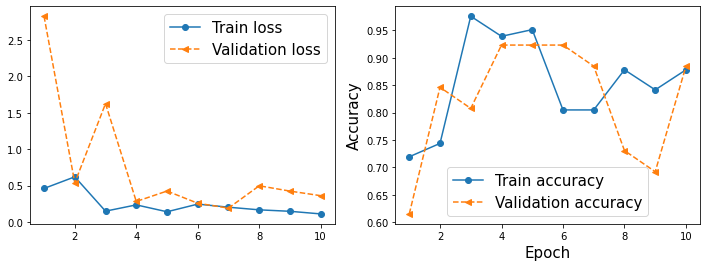

In [23]:
#Plot learning curve
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize = 15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<',
        label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size=15)
plt.show()




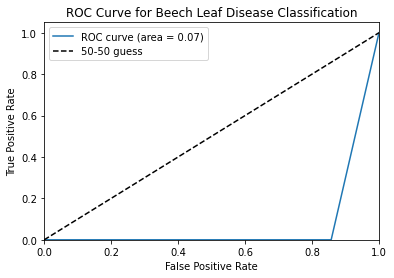

In [28]:
# Plot the ROC curve
#fpr is hist[7]
#tpr is hist[8]
#roc_auc is hist[9]

plt.figure()  
plt.plot(hist[7], hist[8], label='ROC curve (area = %0.2f)' % hist[9])
plt.plot([0, 1], [0, 1], 'k--', label='50-50 guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Beech Leaf Disease Classification')
plt.legend()
plt.show()